In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

%matplotlib widget

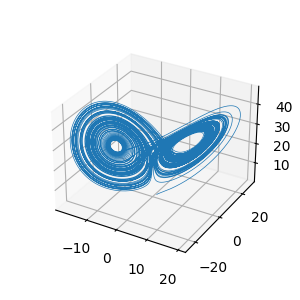

In [28]:
def lorenz(Z, t, sigma, rho, beta):
    x, y, z = Z
    return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

x0 = [1, 1, 1]
t = np.linspace(0, 100, 100000)
sol = odeint(lorenz, x0, t, args=(10, 28, 8/3))

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol[:,0], sol[:,1], sol[:,2], lw=0.5)
plt.show()


In [29]:
# Build hankel matrix

delays = 100
sysdim = sol.shape[1]
dt = t[1] - t[0]

def build_hankel(x, delays):
    H = np.zeros((delays, len(x)-delays))
    for i in range(delays):
        H[i, :] = x[i: i+H.shape[1]]
    
    return H

measurements = sol[:, 0]
H = build_hankel(measurements, delays)
print('H_shape: ', H.shape)
print('dt : {}'.format(dt*delays))

H_shape:  (100, 99900)
dt : 0.10000100001000009


We would like to find a mapping between the time delays $\mathbf{\hat{y}} = [x_i, x_{i+1}, \ldots, x_{i+n-1}]$ and the full state system $\mathbf z_i = [x_i, y_i, z_i]$

$$ \mathbf z = \mathbf f(\hat{\mathbf y}) $$

Can we approximate the function $\mathbf f$ by a neural network?

In [30]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

# Define model
class network(nn.Module):
    def __init__(self, input_dim=100, output_dim=3):
        super(network, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim 
        self.l1 = nn.Linear(self.input_dim, 50)
        self.l2 = nn.Linear(50, 30)
        self.l3 = nn.Linear(30, 10)
        self.l4 = nn.Linear(10, self.output_dim)
    
    def forward(self, x):
        x = F.elu(self.l1(x))
        x = F.elu(self.l2(x))
        x = F.elu(self.l3(x))
        x = self.l4(x)
        return x

model = network(delays, sysdim)
print(model)


network(
  (l1): Linear(in_features=100, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=30, bias=True)
  (l3): Linear(in_features=30, out_features=10, bias=True)
  (l4): Linear(in_features=10, out_features=3, bias=True)
)


### Prepare data

In [31]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

# Prepare data
X = H.T
y = sol[:X.shape[0], :]

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True)


# Turn numpy arrays into PyTorch Tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(x_train.shape)
print(x_test.shape)

trainset = TensorDataset(x_train, y_train)
testset = TensorDataset(x_test, y_test)

# Prepare data for training
bs = 30
trainset_dl = DataLoader(trainset, batch_size=bs, shuffle=False)
testset_dl = DataLoader(testset, batch_size=bs, shuffle=False)

torch.Size([79920, 100])
torch.Size([19980, 100])


In [32]:
# Define optimizer and loss function
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [33]:
# Define training loop
def train_loop(model, loss_fn, optim, trainset_dl, epochs=100):
    # Loop through epochs
    for i in range(epochs):
        # Loop through batches
        for xb, yb in trainset_dl:
            
            # 1. Forward pass
            y_pred = model(xb)

            # 2. Compute loss
            loss = loss_fn(y_pred, yb)

            # 3. Backward pass (compute gradients)
            loss.backward()

            # 4. Apply optimization step
            optim.step()

            # 5. Set gradients to zero 
            # (Pytorch accumulates gradients otherwise) 
            optim.zero_grad()

        print('Epoch: {}, Loss: {}'.format(i, loss))

train_loop(model, loss_fn, optim, trainset_dl, epochs=20)


Epoch: 0, Loss: 2.462639093399048
Epoch: 1, Loss: 1.1332424879074097
Epoch: 2, Loss: 0.1843680441379547
Epoch: 3, Loss: 0.15105091035366058
Epoch: 4, Loss: 0.09804411977529526
Epoch: 5, Loss: 0.09116441011428833
Epoch: 6, Loss: 0.0563996322453022
Epoch: 7, Loss: 0.08487346023321152
Epoch: 8, Loss: 0.03531181439757347
Epoch: 9, Loss: 0.046438489109277725
Epoch: 10, Loss: 0.10916793346405029
Epoch: 11, Loss: 0.03315357491374016
Epoch: 12, Loss: 0.027880579233169556
Epoch: 13, Loss: 0.022153999656438828
Epoch: 14, Loss: 0.036572881042957306
Epoch: 15, Loss: 0.021760625764727592
Epoch: 16, Loss: 0.01963910460472107
Epoch: 17, Loss: 0.016021473333239555
Epoch: 18, Loss: 0.014302044175565243
Epoch: 19, Loss: 0.028830545023083687


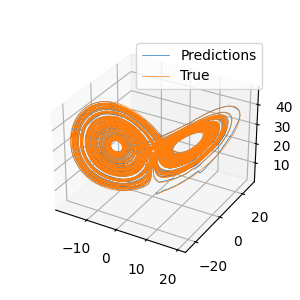

In [34]:
# Plot results

# Get predictions
with torch.no_grad():
    y_pred = model(torch.tensor(H.T, dtype=torch.float32))

# Plot predictions
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
ax.plot(y_pred[:,0], y_pred[:,1], y_pred[:,2], lw=.5, label='Predictions')
ax.plot(y[:,0], y[:,1], y[:,2], lw=.5, label='True')
ax.legend()
plt.show()


In [37]:
# Define training loop
def train_step(model, loss_fn, optim, trainset_dl):
    for xb, yb in trainset_dl:
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        loss.backward()
        optim.step()
        optim.zero_grad()
    return loss

def test_step(model, loss_fn, optim, testset_dl):
    total_loss = 0
    batches = 0
    for xb, yb in testset_dl:
        batches += 1
        with torch.no_grad():
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)
        total_loss += loss.item()
    return total_loss/batches

def fit(model, loss_fn, optim, trainset_dl, testset_dl, epochs=100):
    train_loss = []
    test_loss = []
    for i in range(epochs):
        train_loss.append(train_step(model, loss_fn, optim, trainset_dl))
        test_loss.append(test_step(model, loss_fn, optim, testset_dl))
        print('Epoch: {}, Train loss: {}, Test loss: {}'.format(i, train_loss[-1], test_loss[-1]))
    return train_loss, test_loss

loss_fn = nn.MSELoss()
model2 = network(delays, sysdim)
optim2 = torch.optim.Adam(model2.parameters(), lr=1e-3)
train_loss, test_loss = fit(model2, loss_fn, optim2, trainset_dl, testset_dl, epochs=20)

Epoch: 0, Train loss: 2.265406370162964, Test loss: 1.1353309493925836
Epoch: 1, Train loss: 1.0646253824234009, Test loss: 0.6320039095754201
Epoch: 2, Train loss: 0.24639879167079926, Test loss: 0.15542856926607476
Epoch: 3, Train loss: 0.17191816866397858, Test loss: 0.07077798323409336
Epoch: 4, Train loss: 0.1362232118844986, Test loss: 0.054818975487472235
Epoch: 5, Train loss: 0.11195818334817886, Test loss: 0.05274316801077074
Epoch: 6, Train loss: 0.08697792887687683, Test loss: 0.05301645151465326
Epoch: 7, Train loss: 0.06684254109859467, Test loss: 0.04206128051789763
Epoch: 8, Train loss: 0.05434276908636093, Test loss: 0.042486781724267175
Epoch: 9, Train loss: 0.05980704724788666, Test loss: 0.04704617610475322
Epoch: 10, Train loss: 0.04319890961050987, Test loss: 0.034163788002957635
Epoch: 11, Train loss: 0.037405725568532944, Test loss: 0.04193644499959978
Epoch: 12, Train loss: 0.03943992033600807, Test loss: 0.04685605353991817
Epoch: 13, Train loss: 0.026803186163

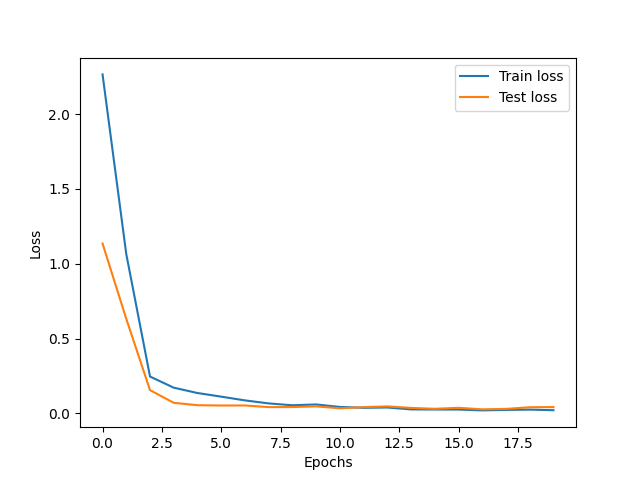

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_loss, label='Train loss')
ax.plot(test_loss, label='Test loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()


### Build an autoencoder to find non-linear dominant modes

In [39]:
class encoder(nn.Module):
    def __init__(self, input_dim=100, output_dim=3):
        super(encoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim 
        self.l1 = nn.Linear(self.input_dim, 50)
        self.l2 = nn.Linear(50, 30)
        self.l3 = nn.Linear(30, 10)
        self.l4 = nn.Linear(10, self.output_dim)
    
    def forward(self, x):
        x = F.elu(self.l1(x))
        x = F.elu(self.l2(x))
        x = F.elu(self.l3(x))
        x = self.l4(x)
        return x

class decoder(nn.Module):
    def __init__(self, input_dim=3, output_dim=100):
        super(decoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim 
        self.l1 = nn.Linear(self.input_dim, 10)
        self.l2 = nn.Linear(10, 30)
        self.l3 = nn.Linear(30, 50)
        self.l4 = nn.Linear(50, self.output_dim)
    
    def forward(self, x):
        x = F.elu(self.l1(x))
        x = F.elu(self.l2(x))
        x = F.elu(self.l3(x))
        x = self.l4(x)
        return x

class autoencoder(nn.Module):
    def __init__(self, input_dim=100, latent_dim=3):
        super(autoencoder, self).__init__()
        self.encoder = encoder(input_dim, latent_dim)
        self.decoder = decoder(latent_dim, input_dim)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

AEmodel = autoencoder(input_dim=100, latent_dim=3)

# Prepare data for training
bs = 30
AEtrainset = TensorDataset(x_train, x_train)
AEtestset = TensorDataset(x_test, x_test)

# Prepare data for training
AEtrainset_dl = DataLoader(AEtrainset, batch_size=bs, shuffle=False)
AEtestset_dl = DataLoader(AEtestset, batch_size=bs, shuffle=False)

# Define optimizer and loss function
optimAE = torch.optim.Adam(AEmodel.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_loss, test_loss = fit(AEmodel, loss_fn, optimAE, AEtrainset_dl, AEtestset_dl, epochs=20)



Epoch: 0, Train loss: 0.013387362472712994, Test loss: 0.013370116216105383
Epoch: 1, Train loss: 0.004996154457330704, Test loss: 0.004289994054745222
Epoch: 2, Train loss: 0.003713774960488081, Test loss: 0.0028754087528927033
Epoch: 3, Train loss: 0.003613042877987027, Test loss: 0.004325106992056263
Epoch: 4, Train loss: 0.0035032574087381363, Test loss: 0.004237087044932015
Epoch: 5, Train loss: 0.001107899472117424, Test loss: 0.0013809582443492538
Epoch: 6, Train loss: 0.004384484142065048, Test loss: 0.011402722508241018
Epoch: 7, Train loss: 0.0009254572214558721, Test loss: 0.0008016142297334069
Epoch: 8, Train loss: 0.016119899228215218, Test loss: 0.07765452718703418
Epoch: 9, Train loss: 0.000912176794372499, Test loss: 0.0006456899925531168
Epoch: 10, Train loss: 0.0008533023064956069, Test loss: 0.0007552219469655394
Epoch: 11, Train loss: 0.001846475643105805, Test loss: 0.0013187912244009912
Epoch: 12, Train loss: 0.001634789165109396, Test loss: 0.0007022660006782986


TypeError: 'autoencoder' object is not subscriptable

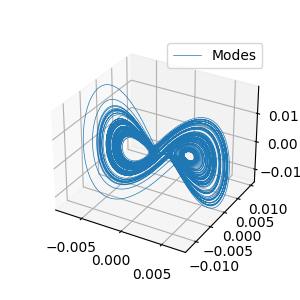

In [46]:
# Find linear modes

u, s, v = np.linalg.svd(H, full_matrices=False)
modes = v.T

# Plot modes
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Linear modes')
ax.plot(modes[:,0], modes[:,1], modes[:,2], lw=.5, label='Modes')
ax.legend()
plt.show()


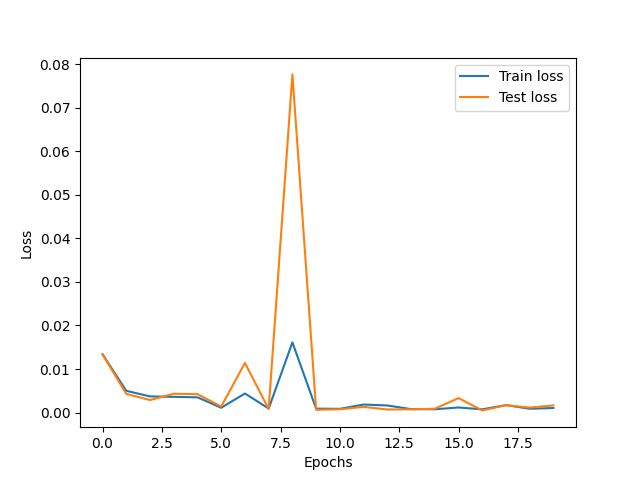

In [41]:
# plot train and test losses

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_loss, label='Train loss')
ax.plot(test_loss, label='Test loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()


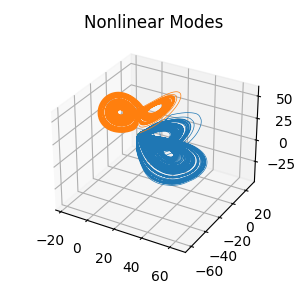

In [47]:
# Plot results
hankel = torch.tensor(H.T, dtype=torch.float32)
latent_z = AEmodel.encoder(hankel).detach().numpy()

# Plot predictions
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Nonlinear Modes')
ax.plot(latent_z[:,0], latent_z[:,1], latent_z[:,2], lw=.5, label='Latent space')
ax.plot(y[:,0], y[:,1], y[:,2], lw=.5, label='Original Lorenz')
ax.plot(modes[:,0], modes[:,1], modes[:,2], lw=.5, label='Linear modes')
ax.legend()
plt.show()


Visualize Layers

In [56]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

AEmodel.encoder.l1.register_forward_hook(get_activation('l1'))
output_l1 = AEmodel(hankel)
l1_output = activation['l1'].detach().numpy()

AEmodel.encoder.l2.register_forward_hook(get_activation('l2'))
output_l2 = AEmodel(hankel)
l2_output = activation['l2'].detach().numpy()

AEmodel.encoder.l3.register_forward_hook(get_activation('l3'))
output_l3 = AEmodel(hankel)
l3_output = activation['l3'].detach().numpy()

output_list = [l1_output, l2_output, l3_output]

In [57]:
l1_output.shape

(99900, 50)

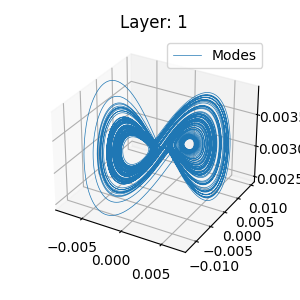

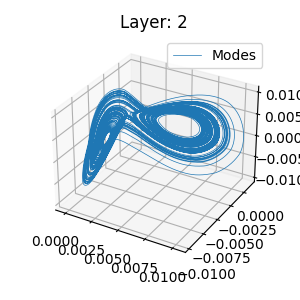

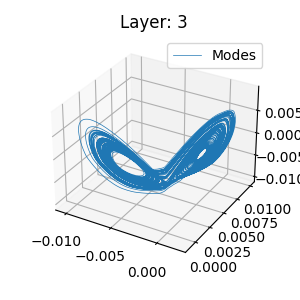

In [60]:
for i, out in enumerate(output_list):
    # SVD every output layer and plot
    u, s, v = np.linalg.svd(output_list[i].T, full_matrices=False)
    modes = v.T
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Layer: {}'.format(i+1))
    ax.plot(modes[:,0], modes[:,1], modes[:,2], lw=.5, label='Modes')
    ax.legend()
    plt.show()


Save Model

In [71]:
# Save model
torch.save(AEmodel.state_dict(), 'AEmodel.pt')

# Load model
AEmodel2 = autoencoder(input_dim=100, latent_dim=3)
AEmodel2.load_state_dict(torch.load('AEmodel.pt'))
AEmodel2.eval()

# print and compare first parameter of AE model and loaded model
print(AEmodel.encoder.l1.weight[0])
print(AEmodel.encoder.l1.weight[0] == AEmodel2.encoder.l1.weight[0])



tensor([ 0.2151,  0.0725,  0.0400,  0.1983,  0.1407,  0.1863,  0.1802,  0.1565,
         0.1385,  0.2244,  0.1741,  0.0329,  0.0364,  0.1417,  0.0912,  0.1129,
         0.2082,  0.0620,  0.2135,  0.1572,  0.0399,  0.1164,  0.1948,  0.0099,
         0.0565,  0.0606,  0.0403,  0.1022,  0.1453,  0.1785,  0.0412,  0.0848,
         0.0992,  0.0921,  0.0461,  0.0627, -0.0197,  0.1041,  0.0878,  0.1366,
         0.0035,  0.1339, -0.0067,  0.1071, -0.0411,  0.1137,  0.0126,  0.0604,
         0.0784, -0.0074, -0.0214, -0.0695, -0.0253, -0.0303, -0.0296, -0.0645,
        -0.0319, -0.0260,  0.0933,  0.0786,  0.0135, -0.0036,  0.0310, -0.0679,
        -0.0599, -0.0447, -0.0967,  0.0375, -0.0691, -0.1024, -0.0453, -0.1338,
        -0.0025,  0.0094, -0.0321, -0.1617, -0.0908,  0.0193, -0.1208, -0.1203,
        -0.1226,  0.0023, -0.1091, -0.0775, -0.0179, -0.0682, -0.1499, -0.1008,
        -0.0760, -0.0617, -0.0385, -0.0722, -0.0888, -0.1177, -0.2144, -0.2300,
        -0.2348, -0.0696, -0.2264, -0.09

## Can you build a predictor that integrates the time series in time?

$$ \mathbf z_{i+1} = \mathbf f(\mathbf z_{i}) $$
